# "Accelerate Langevin Sampling with Birth-Death Process and Exploration Component" 
## Lezhi TAN, Jianfeng LU [2023]

The goal of this notebook and project is to implement the algorithms presented in this paper and to reproduce at least one experiment.
The experiment we chose to reproduce was the simplest one: a mixture of four well-separated and heterogeneous 2D Gaussian Distributions. 
There are 5 separate Python files which we will go over in this order:
- ULA.py - implements the Langevin Update for the target distribution' potential (Algorithm 2)
- Exploration_Component.py - implements Algorithm 3 of the paper that is the innovation brought up by the authors
- BDLS.py - implements Algorithm 4 which is the classic Birth-Death Process accelerated Langevin Sampling
- Metropolized_Transition_Operator.py - implements the transition from current particle population to newer ones that were sampled using the new information on the modes obtained by the exploration component.
- BDEC.py - puts together all previous parts to correspond to Algorithm 1.

The interest of the paper is to use at all times two separate populations of particles: one target population which is sampled from the target temperature Beta=1 and one 'hot' population that is sampled from the same distribution but using a warmer temperature Beta_hot=0.05.
The second population will help the experiment to explore faster and better the probability space to better detect new modes of the distribution.


## Why introduce birth-death dynamics?
- Birth-death dynamics can transport mass more directly by replicating low-energy particles and deleting high-energy ones, accelerating convergence compared to the diffusive behavior of LMC. 
- LMC tends to be trapped in energy landscapes with deep local minima and BD mechanisms introduce non-local moves via particle duplication/death that help escape these traps more effectively.
- In high-dimensionsal spaces, pure diffusion may require exponentially many steps to explore the space, whereas birth-death mechanisms bias the sampling toward regions of low energy more efficiently.


## Comments
Please note the code is not optimized yet, several operations could be vectorized, some parameters could be finetuned to have iterations that run faster

In [2]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from ula import GaussianMixtureULA
from Metropolized_Transition_Operator import MetropolizedTransitionOperator
from Exploration_Component import exploration_component
from BDLS import BDLS_algo, kernel
from BDEC import BDEC
import matplotlib.pyplot as plt

In [105]:
kernel(1,2,sigma=0.05)

8.810158918314533e-86

In [3]:
%load_ext autoreload
%autoreload 2

# Running the Experiment 
The parameters used here are the same as the one used in the original experiment from the paper.

In [4]:
mu_0=np.array([[0,8]])
sigma_0=np.array([[0.3,0],[0,0.01]])
N_init= 2000
temp_hot=0.05

weights = np.full(4, 1/4)

means = np.array([
    [ 0.0, 8.0],
    [ 0.0, 2.0],
    [-3.0, 5.0],
    [ 3.0, 5.0],
])

covs = np.array([
    [[1.2, 0.0], [0.0, 0.01]],
    [[1.2, 0.0], [0.0, 0.01]],
    [[0.01, 0.0], [0.0, 2.0]],
    [[0.01, 0.0], [0.0, 2.0]],
])

init_particles_target=multivariate_normal.rvs(mean=mu_0[0], cov=sigma_0, 
                                              size=N_init)
init_particles_hot=multivariate_normal.rvs(mean=mu_0[0], cov=sigma_0/temp_hot, 
                                           size=N_init)
delta_t=0.005
J=5 #Please note that the more iterations we want to perform the longer each 
    #iteration is because the number of within-temperature updates scales with 
    # the number of total iterations in this implementation, might be a mistake.
T=6 
B=12
thr=2



In [6]:
bdec=BDEC(mu_0,sigma_0,1,thr,B,N_init,weights,means,covs,delta_t,T,
          init_particles_hot,init_particles_target,J,temp_hot=0.05,temp_target=1
          )

bdec.run()

Debut de la boucle 1


LinAlgError: Singular matrix

# Results Analysis
We analyze the results of our algorithm the same way as in the paper. We estimate via Monte-Carlo the values of three different functions using the resulting particle population. We only compare it however to a ground truth which is the value of those three functions by Monte-Carlo method using samples from the target distribution. The three functions used are:
- f(x,y) -> |x|
- f(x,y) -> y
- f(x,y) -> x^2/3 + y^2/5.
The results are shown in the plots.

Note: The results were obtained before correcting the Langevin updatde formula.

In [90]:
def trace_expectations(particle_history, functions, thin=1):
    
    T = len(particle_history)

    
    estimates = {name: [] for name in functions}
    iter_indices = list(range(0, T, thin))

    for t in iter_indices:
        X = particle_history[t]        
        N = X.shape[0]
        for name, f in functions.items():
            
            vals = np.array([f(x) for x in X]) 
            estimates[name].append(vals.mean())

    
    for name in estimates:
        estimates[name] = np.array(estimates[name])

    return estimates, np.array(iter_indices)

functions={'f1': lambda x: np.abs(x[0]), 'f2': lambda x: x[1], 'f3': lambda x: 
           ((x[0]**2)/3) + ((x[1]**2)/5)}
est=trace_expectations(bdec.particules, functions, thin=1)

In [91]:
#This cell is used to first sample particles from the target distribution and 
# estimate by Monte Carlo a 'ground truth' value of E(f) using those samples
def sample_from_ground_truth(weights,means,covs,M):
    comp = np.random.choice(len(weights), size=M, p=weights)
    X = np.zeros((M, means.shape[1]))
    for i in range(len(weights)):
        ni = np.sum(comp == i)
        if ni>0:
            X[comp==i] = np.random.multivariate_normal(
                means[i], covs[i], size=ni
            )
    return X
X_truth=sample_from_ground_truth(weights,means,covs,10000)
ground_truth = {
    name: np.mean([f(x) for x in X_truth])
    for name, f in functions.items()
}

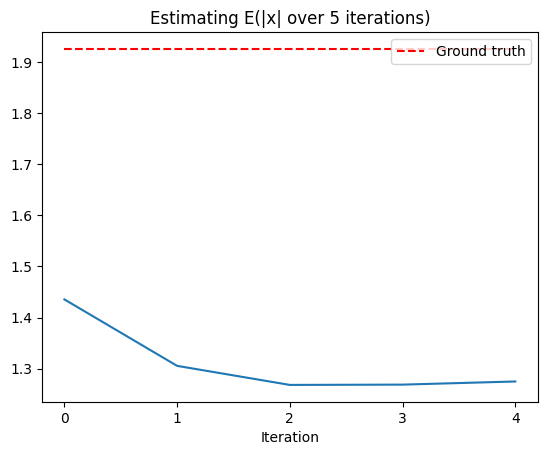

In [92]:
y = est[0]['f1']        
x = [i for i in range(0, len(est[0]['f1']))]              


plt.figure()


plt.plot(x, y)


gt = ground_truth['f1']
plt.hlines(gt, x[0], x[-1], colors='r', linestyles='--', label='Ground truth')


plt.title('Estimating E(|x| over 5 iterations)')
plt.xlabel('Iteration')
plt.xticks(x)

plt.legend()


plt.show()

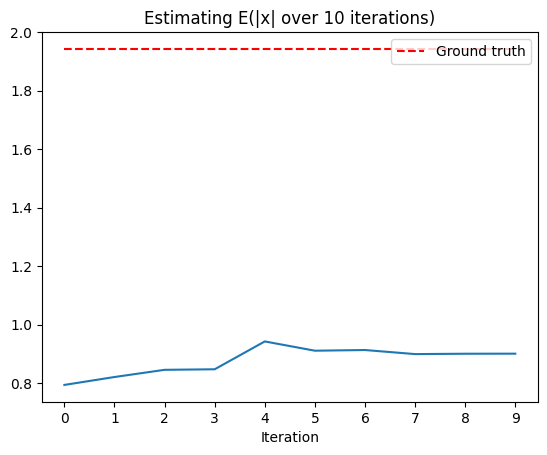

In [ ]:
y = est[0]['f1']        
x = [i for i in range(0, len(est[0]['f1']))]              


plt.figure()


plt.plot(x, y)


gt = ground_truth['f1']
plt.hlines(gt, x[0], x[-1], colors='r', linestyles='--', label='Ground truth')


plt.title('Estimating E(|x| over 10 iterations)')
plt.xlabel('Iteration')
plt.xticks(x)

plt.legend()


plt.show()

In [103]:
print('Hello World' \
'')

Hello World


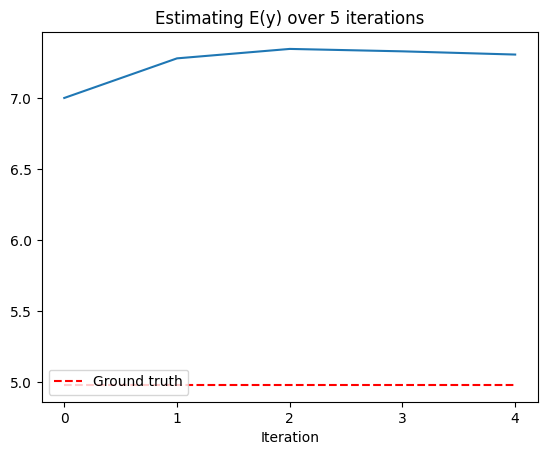

In [93]:
y = est[0]['f2']       
x = [i for i in range(0, len(est[0]['f1']))]            


plt.figure()


plt.plot(x, y)


gt = ground_truth['f2']
plt.hlines(gt, x[0], x[-1], colors='r', linestyles='--', label='Ground truth')


plt.title('Estimating E(y) over 5 iterations')
plt.xlabel('Iteration')
plt.xticks(x)

plt.legend()

plt.show()

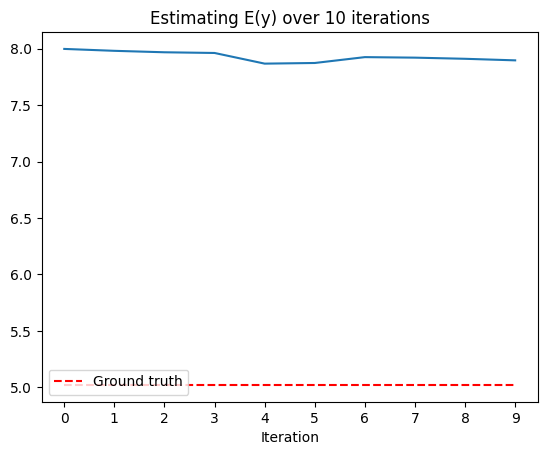

In [ ]:
y = est[0]['f2']       
x = [i for i in range(0, len(est[0]['f1']))]            


plt.figure()


plt.plot(x, y)


gt = ground_truth['f2']
plt.hlines(gt, x[0], x[-1], colors='r', linestyles='--', label='Ground truth')


plt.title('Estimating E(y) over 10 iterations')
plt.xlabel('Iteration')
plt.xticks(x)

plt.legend()

plt.show()

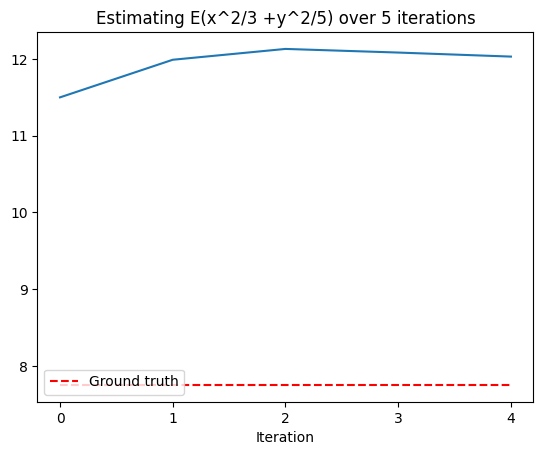

In [94]:
y = est[0]['f3']        
x = [i for i in range(0, len(est[0]['f1']))]              


plt.figure()


plt.plot(x, y)


gt = ground_truth['f3']
plt.hlines(gt, x[0], x[-1], colors='r', linestyles='--', label='Ground truth')


plt.title('Estimating E(x^2/3 +y^2/5) over 5 iterations')
plt.xlabel('Iteration')
plt.xticks(x)

plt.legend()


plt.show()

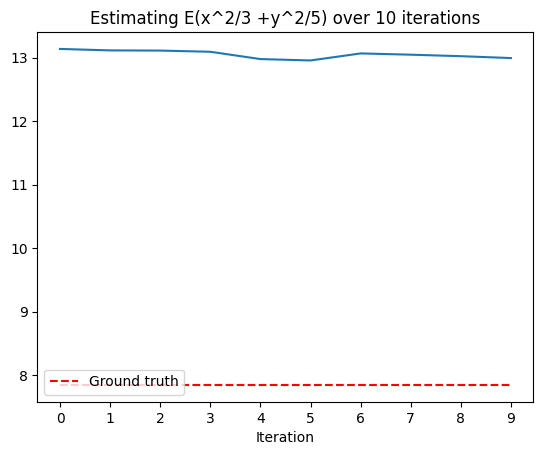

In [ ]:
y = est[0]['f3']        
x = [i for i in range(0, len(est[0]['f1']))]              


plt.figure()


plt.plot(x, y)


gt = ground_truth['f3']
plt.hlines(gt, x[0], x[-1], colors='r', linestyles='--', label='Ground truth')


plt.title('Estimating E(x^2/3 +y^2/5) over 10 iterations')
plt.xlabel('Iteration')
plt.xticks(x)

plt.legend()


plt.show()